# Project: Marketing Campaigns — EDA & Hypothesis Testing
# Step 1: imports


In [40]:
# Cell 2 - imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pd.options.display.max_columns = 200

### Load data & quick checks

In [41]:
# Cell 3 - load and quick checks (adjust path if needed)
df = pd.read_csv('marketing_data.csv')   # replace with correct path if needed
print("Rows, cols:", df.shape)
display(df.head())
display(df.info())

Rows, cols: (2240, 28)


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country
0,1826,1970,Graduation,Divorced,"$84,835.00",0,0,6/16/14,0,189,104,379,111,189,218,1,4,4,6,1,0,0,0,0,0,1,0,SP
1,1,1961,Graduation,Single,"$57,091.00",0,0,6/15/14,0,464,5,64,7,0,37,1,7,3,7,5,0,0,0,0,1,1,0,CA
2,10476,1958,Graduation,Married,"$67,267.00",0,1,5/13/14,0,134,11,59,15,2,30,1,3,2,5,2,0,0,0,0,0,0,0,US
3,1386,1967,Graduation,Together,"$32,474.00",1,1,5/11/14,0,10,0,1,0,0,0,1,1,0,2,7,0,0,0,0,0,0,0,AUS
4,5371,1989,Graduation,Single,"$21,474.00",1,0,4/8/14,0,6,16,24,11,0,34,2,3,1,2,7,1,0,0,0,0,1,0,SP


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   2240 non-null   int64 
 1   Year_Birth           2240 non-null   int64 
 2   Education            2240 non-null   object
 3   Marital_Status       2240 non-null   object
 4    Income              2216 non-null   object
 5   Kidhome              2240 non-null   int64 
 6   Teenhome             2240 non-null   int64 
 7   Dt_Customer          2240 non-null   object
 8   Recency              2240 non-null   int64 
 9   MntWines             2240 non-null   int64 
 10  MntFruits            2240 non-null   int64 
 11  MntMeatProducts      2240 non-null   int64 
 12  MntFishProducts      2240 non-null   int64 
 13  MntSweetProducts     2240 non-null   int64 
 14  MntGoldProds         2240 non-null   int64 
 15  NumDealsPurchases    2240 non-null   int64 
 16  NumWeb

None

### Find & normalize key column names

In [42]:
# Cell 4 - helper to find columns by substring
def find_cols(df, substr):
    return [c for c in df.columns if substr.lower() in c.lower()]

def find_first(df, *subs):
    for s in subs:
        cols = find_cols(df, s)
        if cols:
            return cols[0]
    return None

dt_col = find_first(df, 'dt_customer', 'date')
income_col = find_first(df, 'income')
edu_col = find_first(df, 'educ', 'education')
mar_col = find_first(df, 'marital', 'mar')
year_col = find_first(df, 'year_birth', 'birth', 'year')
kid_col = find_first(df, 'kid')
teen_col = find_first(df, 'teen')
print("Detected cols:", dt_col, income_col, edu_col, mar_col, year_col, kid_col, teen_col)

Detected cols: Dt_Customer  Income  Education Marital_Status Year_Birth Kidhome Teenhome


### Parse dates & clean Income

In [45]:
# Cell 5 - parse dates and clean income
if dt_col:
    df[dt_col] = pd.to_datetime(df[dt_col], errors='coerce')

if income_col:
    df[income_col] = (df[income_col].astype(str)
                      .str.replace(',','', regex=False)
                      .str.replace(' ','', regex=False)
                      .str.replace(r'[^0-9.-]', '', regex=True))
    df[income_col] = pd.to_numeric(df[income_col], errors='coerce')

print("Income missing before imputation:", df[income_col].isna().sum() if income_col else 'Income not found')
df[[income_col]].describe()

Income missing before imputation: 24


,Income
count,2216.000000
mean,52247.251354
std,25173.076661
min,1730.000000
25%,35303.000000
50%,51381.500000
75%,68522.000000
max,666666.000000


### Clean categories (education & marital)

In [46]:
# Cell 6 - clean categorical columns
def clean_cat(s):
    return s.astype(str).str.strip().str.title().replace({'Nan':'Unknown','N/A':'Unknown'})

if edu_col:
    print("Education - before:", df[edu_col].unique()[:20])
    df[edu_col] = clean_cat(df[edu_col])
    print("Education - after:", df[edu_col].unique()[:20])

if mar_col:
    print("Marital - before:", df[mar_col].unique()[:20])
    df[mar_col] = clean_cat(df[mar_col])
    print("Marital - after:", df[mar_col].unique()[:20])

Education - before: ['Graduation' 'PhD' '2n Cycle' 'Master' 'Basic']
Education - after: ['Graduation' 'Phd' '2N Cycle' 'Master' 'Basic']
Marital - before: ['Divorced' 'Single' 'Married' 'Together' 'Widow' 'YOLO' 'Alone' 'Absurd']
Marital - after: ['Divorced' 'Single' 'Married' 'Together' 'Widow' 'Yolo' 'Alone' 'Absurd']


### Income imputation by (Education × Marital)

In [47]:
# Cell 7 - groupwise mean imputation (education x marital)
if income_col and edu_col and mar_col:
    grp_mean = df.groupby([edu_col, mar_col])[income_col].transform('mean')
    before = df[income_col].isna().sum()
    df[income_col] = df[income_col].fillna(grp_mean)
    df[income_col] = df[income_col].fillna(df[income_col].median())  # fallback
    after = df[income_col].isna().sum()
    print(f"Income missing before: {before}; after imputation: {after}")
    display(df[[edu_col, mar_col, income_col]].head())
else:
    print("Required columns for groupwise imputation not all found.")

Income missing before: 24; after imputation: 0


,Education,Marital_Status,Income
0,Graduation,Divorced,84835.0
1,Graduation,Single,57091.0
2,Graduation,Married,67267.0
3,Graduation,Together,32474.0
4,Graduation,Single,21474.0


### Feature engineering (age, total_children, total_spending, total_purchases)

In [48]:
# Cell 8 - feature engineering
# total_children
if kid_col or teen_col:
    k = kid_col if kid_col else None
    t = teen_col if teen_col else None
    df['total_children'] = 0
    if k:
        df['total_children'] += df[k].fillna(0).astype(float)
    if t:
        df['total_children'] += df[t].fillna(0).astype(float)
else:
    print("Kid/Teen columns not found — total_children remains 0")

# age (using year of birth if present)
if year_col and dt_col:
    try:
        if np.issubdtype(df[year_col].dtype, np.number):
            df['age'] = df[dt_col].dt.year - df[year_col]
        else:
            df[year_col] = pd.to_datetime(df[year_col], errors='coerce')
            df['age'] = ((df[dt_col] - df[year_col]).dt.days / 365.25).astype(int)
    except Exception as e:
        print("Age calc issue:", e)

# total_spending: sum columns with 'Mnt' or 'Amount' or 'Spend'
mnt_cols = [c for c in df.columns if any(k in c.lower() for k in ['mnt', 'amount', 'spend'])]
if not mnt_cols:
    # try product names often present
    mnt_cols = [c for c in df.columns if c.lower().startswith('mnt')]
df['total_spending'] = df[mnt_cols].sum(axis=1) if mnt_cols else 0

# total_purchases: sum columns with 'Num' and 'Purch'
purchase_cols = [c for c in df.columns if 'num' in c.lower() and 'purch' in c.lower()]
if not purchase_cols:
    # try common channel names
    purchase_cols = [c for c in df.columns if any(s in c.lower() for s in ['web', 'catalog', 'store', 'purch', 'purchase']) and df[c].dtype != object]
df['total_purchases'] = df[purchase_cols].sum(axis=1) if purchase_cols else 0

print("Features created. Sample:")
display(df.head()[['age','total_children','total_spending','total_purchases']].head())
print("Spending cols used:", mnt_cols)
print("Purchase cols used:", purchase_cols)

Features created. Sample:


,age,total_children,total_spending,total_purchases
0,44,0.0,1190,15
1,53,0.0,577,18
2,56,1.0,251,11
3,47,2.0,11,4
4,25,1.0,91,8


Spending cols used: ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
Purchase cols used: ['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']


### EDA: distributions, boxplots, correlation

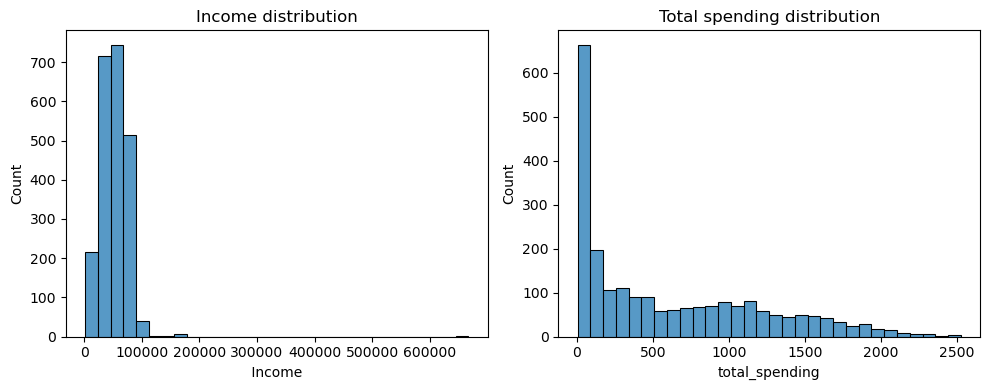

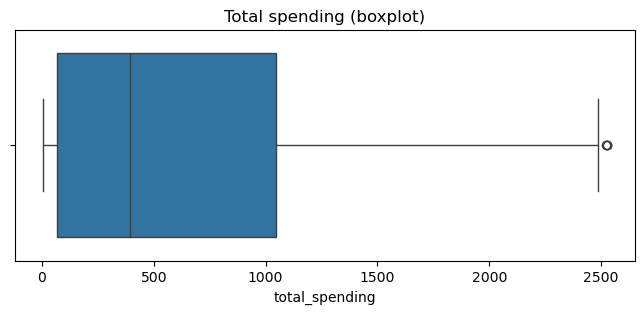

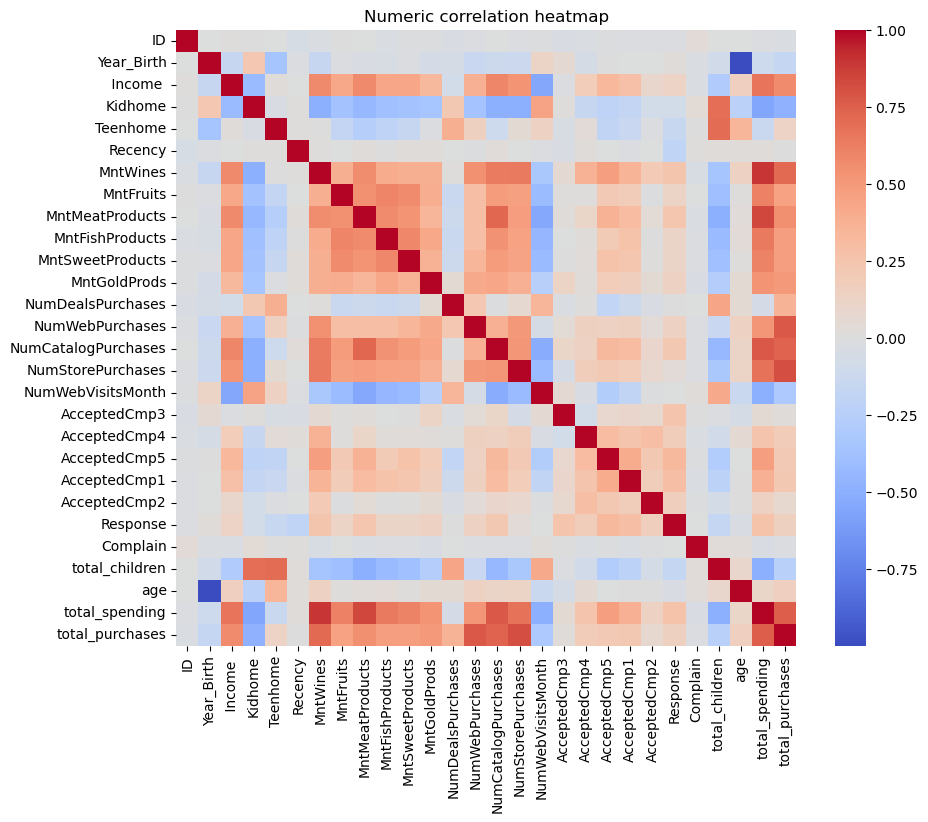

In [49]:
# Cell 9 - EDA plots
plt.figure(figsize=(10,4))
if income_col:
    plt.subplot(1,2,1)
    sns.histplot(df[income_col].dropna(), kde=False, bins=30)
    plt.title('Income distribution')
if 'total_spending' in df.columns:
    plt.subplot(1,2,2)
    sns.histplot(df['total_spending'].replace(0,np.nan).dropna(), kde=False, bins=30)
    plt.title('Total spending distribution')
plt.tight_layout()
plt.show()

# Boxplot for total_spending
plt.figure(figsize=(8,3))
sns.boxplot(x=df['total_spending'])
plt.title('Total spending (boxplot)')
plt.show()

# Correlation heatmap (numeric)
num = df.select_dtypes(include=[np.number])
plt.figure(figsize=(10,8))
sns.heatmap(num.corr(), annot=False, cmap='coolwarm')
plt.title('Numeric correlation heatmap')
plt.show()

### Outlier treatment (IQR capping)

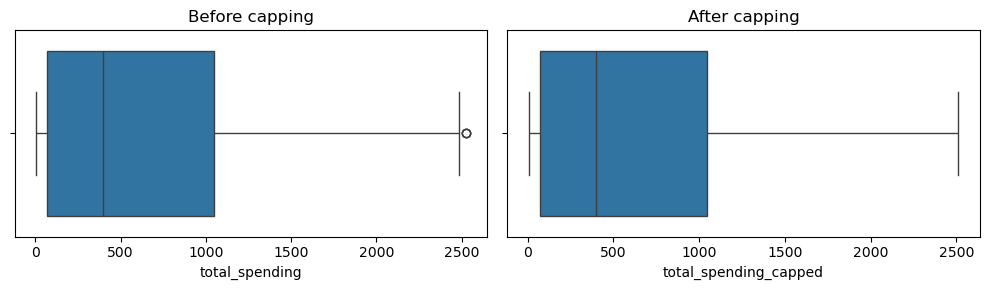

In [50]:
# Cell 10 - IQR capping for total_spending
def cap_iqr(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    low = q1 - k * iqr
    high = q3 + k * iqr
    return series.clip(lower=low, upper=high)

if 'total_spending' in df.columns:
    df['total_spending_capped'] = cap_iqr(df['total_spending'].fillna(0))
    # show before/after
    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1)
    sns.boxplot(x=df['total_spending'])
    plt.title('Before capping')
    plt.subplot(1,2,2)
    sns.boxplot(x=df['total_spending_capped'])
    plt.title('After capping')
    plt.tight_layout()
    plt.show()
else:
    print("No total_spending column found.")

### Hypothesis testing (t-test + chi-square)

In [51]:
# Cell 11 - t-test: Do high-income customers spend more?
if income_col and 'total_spending' in df.columns:
    median_inc = df[income_col].median()
    high = df[df[income_col] > median_inc]['total_spending_capped'].dropna()
    low  = df[df[income_col] <= median_inc]['total_spending_capped'].dropna()
    tstat, pval = stats.ttest_ind(high, low, equal_var=False)
    print("Median income:", median_inc)
    print("High group size:", len(high), "Low group size:", len(low))
    print("t-statistic:", tstat, "p-value:", pval)
    if pval < 0.05:
        print("Interpretation: p < 0.05 -> significant difference in spending between income groups.")
    else:
        print("Interpretation: no significant difference at α=0.05.")
else:
    print("Income or spending data not available for t-test.")

Median income: 51381.5
High group size: 1120 Low group size: 1120
t-statistic: 51.94896175396037 p-value: 0.0
Interpretation: p < 0.05 -> significant difference in spending between income groups.


In [52]:
# Cell 12 - chi-square: response vs education
resp_col = find_first(df, 'response', 'resp')
if resp_col and edu_col:
    ct = pd.crosstab(df[resp_col].fillna('Unknown'), df[edu_col].fillna('Unknown'))
    from scipy.stats import chi2_contingency
    chi2, p, dof, expected = chi2_contingency(ct)
    print("Chi2 p-value:", p)
    if p < 0.05:
        print("Interpretation: p < 0.05 -> response depends on education (reject independence).")
    else:
        print("Interpretation: no evidence of dependence at α=0.05.")
    display(ct)
else:
    print("Missing response or education column; cannot run chi-square.")

Chi2 p-value: 0.00012226975294505314
Interpretation: p < 0.05 -> response depends on education (reject independence).


Education,2N Cycle,Basic,Graduation,Master,Phd
Response,,,,,
0,181,52,975,313,385
1,22,2,152,57,101


### Simple predictive model (logistic regression)

In [53]:
# Cell 13 - simple logistic regression for response
resp_col = find_first(df, 'response', 'resp')
if resp_col:
    # build feature list from engineered features and reliable numeric columns
    candidate_feats = ['Age','age','Income','income','total_spending_capped','total_spending','total_purchases','total_children']
    features = [f for f in candidate_feats if f in df.columns]
    if not features:
        # fallback to numeric columns
        features = df.select_dtypes(include=[np.number]).columns.tolist()
        features = [f for f in features if f != resp_col][:6]
    print("Features used:", features)
    X = df[features].fillna(0)
    # ensure binary response
    y = df[resp_col]
    # convert to binary if not numeric
    if y.dtype == object:
        y = (y != 'No') & (y != '0') & (y != '')
        y = y.astype(int)
    else:
        y = (y != 0).astype(int)
    pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
    scores = cross_val_score(pipe, X, y, cv=5, scoring='accuracy')
    print("CV accuracy (5-fold):", scores.mean(), "±", scores.std())
    # fit and show coefficients
    pipe.fit(X, y)
    coefs = pipe.named_steps['logisticregression'].coef_[0]
    print("Feature coefficients (log-odds):")
    for feat, c in zip(features, coefs):
        print(f"{feat}: {c:.4f}")
else:
    print("Response column not found - cannot run logistic regression.")

Features used: ['age', 'total_spending_capped', 'total_spending', 'total_purchases', 'total_children']
CV accuracy (5-fold): 0.8513392857142857 ± 0.0033407655239052927
Feature coefficients (log-odds):
age: -0.1283
total_spending_capped: 0.3302
total_spending: 0.3303
total_purchases: -0.0732
total_children: -0.1344
